In [1]:
import sys,os
sys.path.append("../")
import random

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.plots import visualize_uncertainty, save_fig
from utils.misc import gen_data
from utils.loss import AleatoricLoss
from utils.metrics import mpiw,picp
from utils.early_stopping import EarlyStopping
from model_utils.mlp import MLPNet
from uncertainty.mc_dropout_regression import mc_dropout_eval

/share/home/shiqing/miniconda3/envs/yym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2

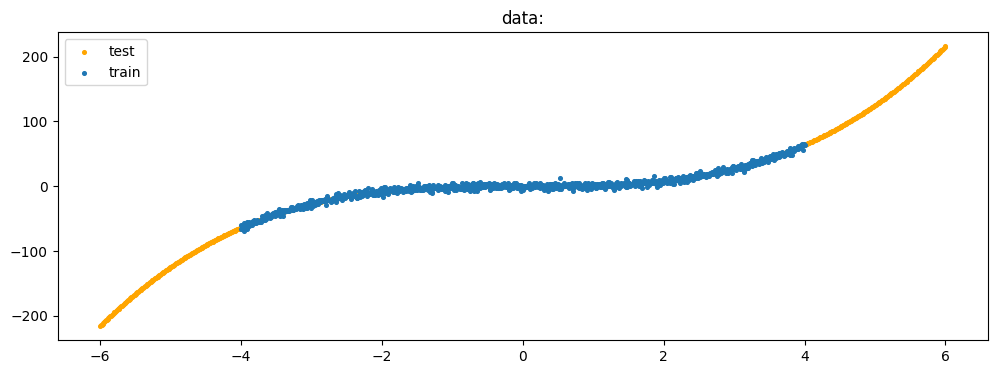

In [3]:
MEAN_FUN = lambda x:x**3
device="cuda:0"
x_train, y_train, x_test, y_test = gen_data(mean_fun=MEAN_FUN,std_const=3,train_abs=4,test_abs=6,occlude=False, 
                                            hetero=False,n_samples=1000)

In [4]:
class MLPNet(nn.Module):
    def __init__(self,n_hidden=64, m_layers=2, p=0.5):
        super().__init__()
        layers = [nn.Linear(1,n_hidden),nn.ReLU(inplace=True)]
        for i in range(m_layers):
            layers += [nn.Linear(n_hidden,n_hidden),nn.ReLU(inplace=True)]
        layers += [nn.Dropout(p),nn.Linear(n_hidden,1)]
        self.ff = nn.Sequential(*layers)
    def forward(self,x):
        x = self.ff(x)
        return x

In [5]:
def train_mlp(model,x_train, y_train, x_test, y_test,num_epochs,device,save_path):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    early_stopping = EarlyStopping(save_path,patience=10000)
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    #Training
    for epoch in (range(num_epochs)):
        model.train()
        x_train= x_train.to(device)
        y_train =y_train.to(device)
        outputs = model(x_train)
        loss = loss_fn(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
        #Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            val_outputs = model(x_test)
            val_loss = loss_fn(val_outputs, y_test).item()

        # if epoch%10000==0:
        #     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

        early_stopping(val_loss, model)
        #达到早停止条件时，early_stop会被置为True
        if early_stopping.early_stop:
            print("Early stopping")
            break #跳出迭代，结束训练

## uncertainty and width

Early stopping


/tmp/ipykernel_344970/4137759539.py:41: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(y_test,torch.tensor(y_pred))


Early stopping
Early stopping
Early stopping


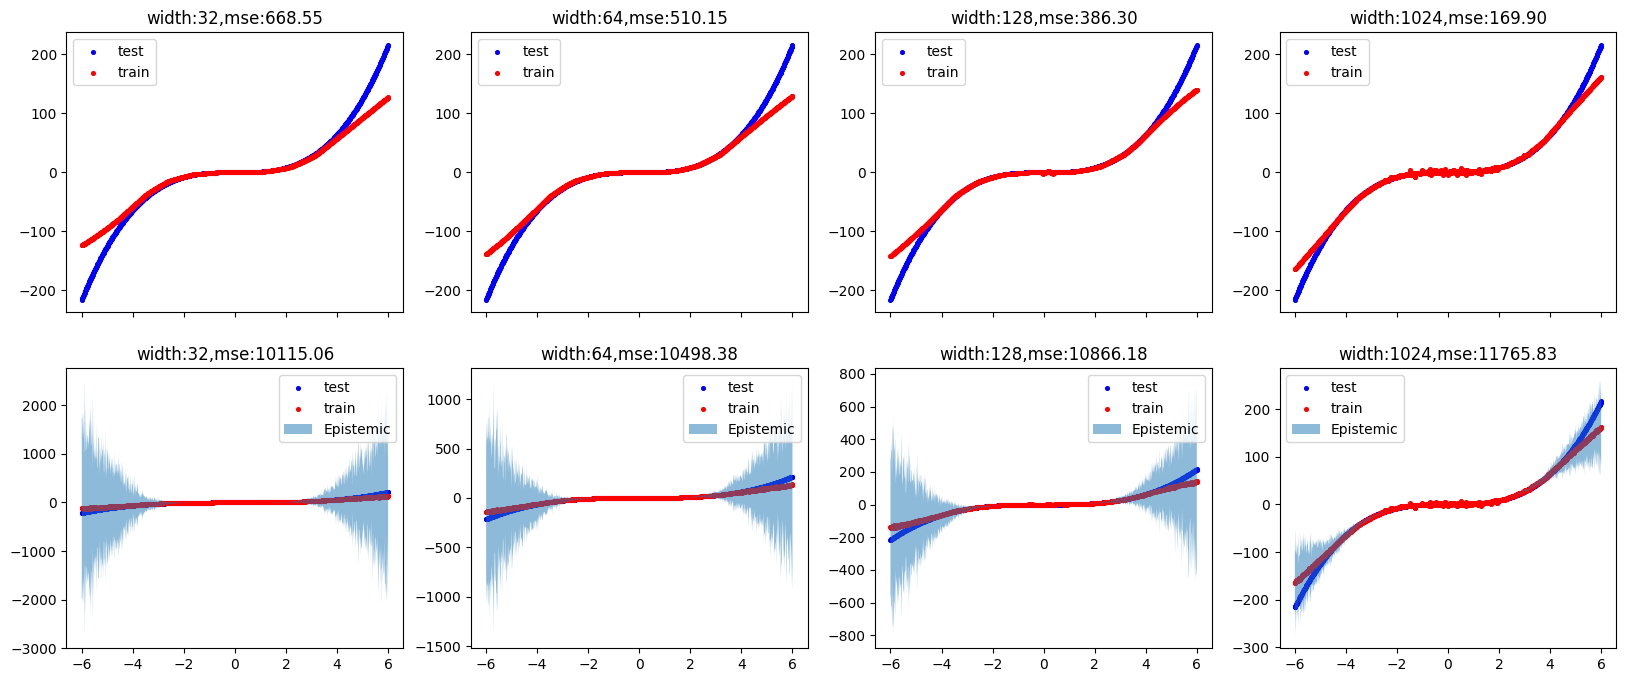

In [6]:
widths = [32,64,128,1024]
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, figsize=(20, 8))
for i, width in enumerate(widths):
    net = MLPNet(width).to(device)
    
    num_epochs = 100000
    save_path=f"../saved_models/regression/deterministic/2023_12_20_15_18_52/mlp_width{width}_best.pth"
    train_mlp(net,x_train, y_train, x_test, y_test,num_epochs,device,save_path)

    checkpoint = torch.load(save_path,map_location=device)
    net.load_state_dict(checkpoint)
    
    net.eval()#关闭dropout
    y_pred = net(x_test.to(device)).cpu().detach().numpy()
    axs[0][i].scatter(x_test, y_test, c="b", s=7, label="test")
    axs[0][i].scatter(x_test, y_pred, c="r", s=7, label="train")
    axs[0][i].legend()
    mse = F.mse_loss(y_test,torch.tensor(y_pred))
    axs[0][i].set_title(f"width:{width},mse:{mse:.2f}")
    
    
    net.train()#打开dropout
    y_preds = []
    for t in range(32):
        y_preds.append(net(x_test.to(device)))
    y_preds = torch.concat(y_preds, axis=1)
    y_var = torch.var(y_preds,dim=1)
    y_pred = torch.mean(y_preds,dim=1)
    axs[1][i].scatter(x_test, y_test, c="b", s=7, label="test")
    y_pred = y_pred.cpu().detach().numpy()
    y_var = y_var.cpu().detach().numpy()
    axs[1][i].scatter(x_test, y_pred, c="r", s=7, label="train")
    axs[1][i].fill_between(
            x_test.squeeze(),
            y_pred - y_var,
            y_pred + y_var,
            label="Epistemic",
            alpha=0.5,
        )
    axs[1][i].legend()
    mse = F.mse_loss(y_test,torch.tensor(y_pred))
    axs[1][i].set_title(f"width:{width},mse:{mse:.2f}")


## uncertainty and depth

/tmp/ipykernel_344970/828526863.py:41: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(y_test,torch.tensor(y_pred))


Early stopping
Early stopping
Early stopping
Early stopping


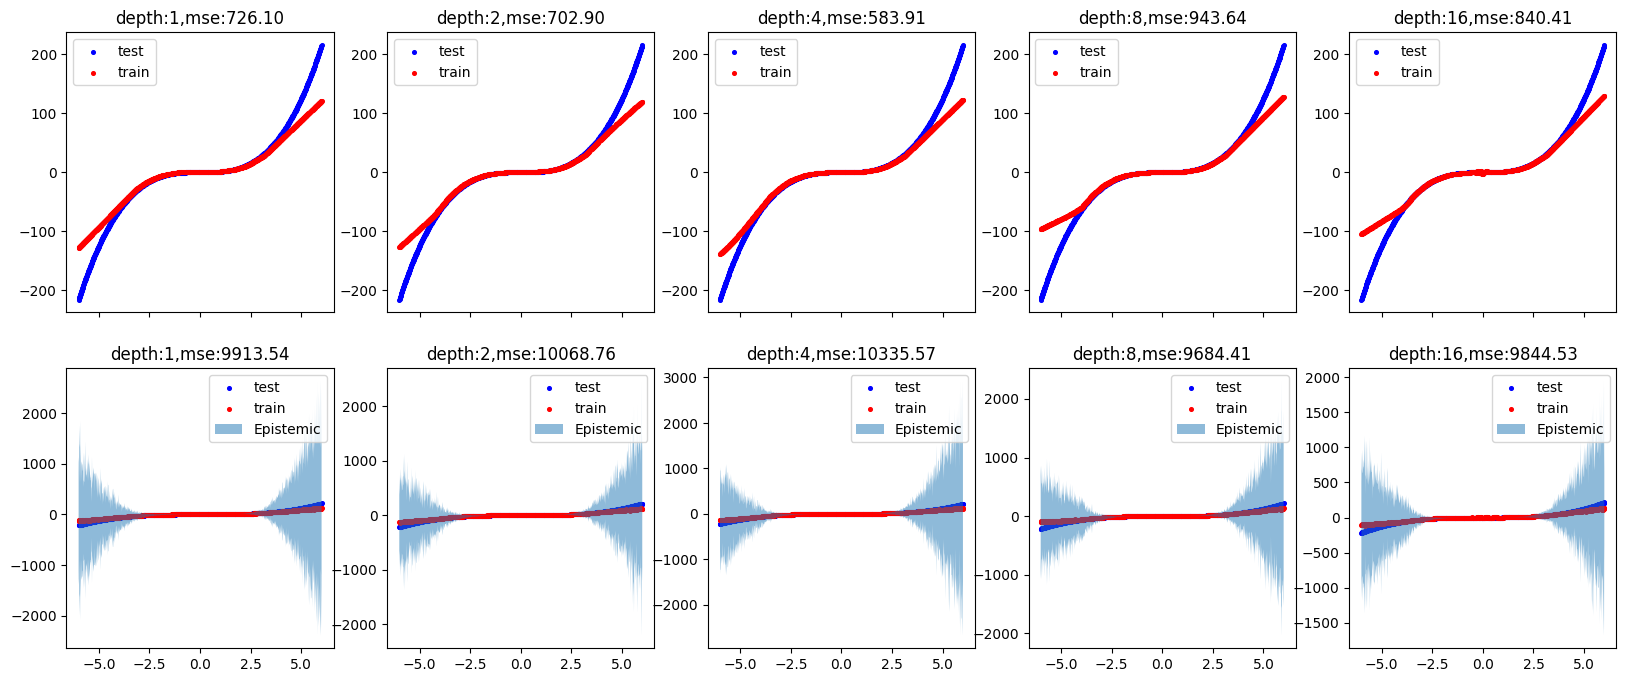

In [7]:
depths = [1,2,4,8,16]
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(20, 8))
for i, depth in enumerate(depths):
    net = MLPNet(32, depth).to(device)
    
    num_epochs = 100000
    save_path=f"../saved_models/regression/deterministic/2023_12_20_15_18_52/mlp_depth{depth}_best.pth"
    train_mlp(net,x_train, y_train, x_test, y_test,num_epochs,device,save_path)

    checkpoint = torch.load(save_path,map_location=device)
    net.load_state_dict(checkpoint)
    
    net.eval()#关闭dropout
    y_pred = net(x_test.to(device)).cpu().detach().numpy()
    axs[0][i].scatter(x_test, y_test, c="b", s=7, label="test")
    axs[0][i].scatter(x_test, y_pred, c="r", s=7, label="train")
    axs[0][i].legend()
    mse = F.mse_loss(y_test,torch.tensor(y_pred))
    axs[0][i].set_title(f"depth:{depth},mse:{mse:.2f}")
    
    
    net.train()#打开dropout
    y_preds = []
    for t in range(32):
        y_preds.append(net(x_test.to(device)))
    y_preds = torch.concat(y_preds, axis=1)
    y_var = torch.var(y_preds,dim=1)
    y_pred = torch.mean(y_preds,dim=1)
    axs[1][i].scatter(x_test, y_test, c="b", s=7, label="test")
    y_pred = y_pred.cpu().detach().numpy()
    y_var = y_var.cpu().detach().numpy()
    axs[1][i].scatter(x_test, y_pred, c="r", s=7, label="train")
    axs[1][i].fill_between(
            x_test.squeeze(),
            y_pred - y_var,
            y_pred + y_var,
            label="Epistemic",
            alpha=0.5,
        )
    axs[1][i].legend()
    mse = F.mse_loss(y_test,torch.tensor(y_pred))
    axs[1][i].set_title(f"depth:{depth},mse:{mse:.2f}")
